# Simulating data to check analysis options

This presents an example of how one can investigate how well-suited to the data at hand a radial binning can be by creating simulated input with known truth and trying different binings.

As an example, we study the case where one wants to extract a pressure profile from a NIKA2 mapping of the C2 cluster, presented in the validation paper.
The C2 cluster is a mock source with $z=0.5, \; M_{500} = 6 \times 10^{14} M_\odot$, with an Arnaud et al. (2010) universal pressure profile.
The NIKA2 map is projected using a gnomonic projection in (RA, dec), on a $6.5'$ square, with $3''$ pixels.
The noise is white, with an RMS map taken from NIKA2 ACTJ0215 observations.
The beam is gaussian with $18''$ FWHM, and we use a smoothed version of the transfer function of Kéruzoré et al. (2020).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import cmocean
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astropy.io import fits
import astropy.units as u
import scipy.stats as ss

In [2]:
import sys
sys.path.append("../..")
import panco2 as p2

## Simulated map creation

Start by reading in the data, giving cluster info, and the size and center of the map to be considered for the fit.
For filtering, we take a $18''$ beam, and a NIKA2-like transfer function

In [3]:
path = "."
ppf = p2.PressureProfileFitter(
    f"{path}/C2_nk2.fits",
    1, 5,
    0.5, 6e14,
    map_size=6.6,
    coords_center=SkyCoord("12h00m00s +00d00m00s")
)

To create the mock map to be used for our investigation, we define a very fine radial binning:

In [4]:
beam_fwhm_arcsec = 18.0
pix_kpc = ppf.cluster.arcsec2kpc(ppf.pix_size)
half_map_kpc = ppf.cluster.arcsec2kpc(ppf.map_size * 60 / 2)
hwhm_kpc = ppf.cluster.arcsec2kpc(beam_fwhm_arcsec / 2)

r_bins = np.logspace(
    np.log10(pix_kpc / 2), np.log10(half_map_kpc * np.sqrt(2)), 100
)
ppf.define_model(r_bins)

We then choose the pressure profile to use to create the mock map.
We'll consider a universal A10 pressure profile:

Text(0, 0.5, '$P_e(r) \\; [{\\rm keV \\cdot cm^{-3}}]$')

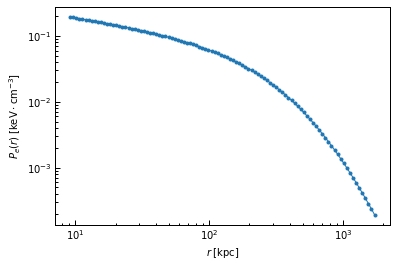

In [5]:
P_bins = p2.utils.gNFW(r_bins, *ppf.cluster.A10_params)
true_prof = [r_bins, P_bins]
fig, ax = plt.subplots()
ax.loglog(r_bins, P_bins, ".-")
ax.set_xlabel("$r \; [{\\rm kpc}]$")
ax.set_ylabel("$P_e(r) \; [{\\rm keV \cdot cm^{-3}}]$")

Add realistic filtering:

In [6]:
tf = np.load(f"{path}/nk2_tf.npz")
ppf.add_filtering(
    beam_fwhm=beam_fwhm_arcsec, ell=tf["ell"], tf=tf["tf_150GHz"], pad=20
)

==> Adding filtering: beam and 1D transfer function


We can then use the `ppf.write_sim_maps` method.
A mock map will be generated using the forward modeling, with realistic noise and filtering, from an input vector in the parameter space.
This vector is the concatenation of the pressure profile values computed above, a conversion coefficient, and a zero level:

In [7]:
par_vec = np.concatenate((P_bins, [-12.0, 0.0]))
np.random.seed(42)
ppf.write_sim_map(par_vec, f"{path}/simulated_map.fits")

The HDUs in the created fits file are as follows (see the function's documentation):

- HDU 0: primary, contains header and no data.
- HDU 1: TOTAL, contains the model map (SZ+PS+noise) and header.
- HDU 2: SZ, contains the SZ model map and header.
- HDU 3: PS, contains the PS model map and header.
- HDU 4: NOISE, contains the noise map realization and header.
- HDU 5: RMS, contains the noise RMS map and header.

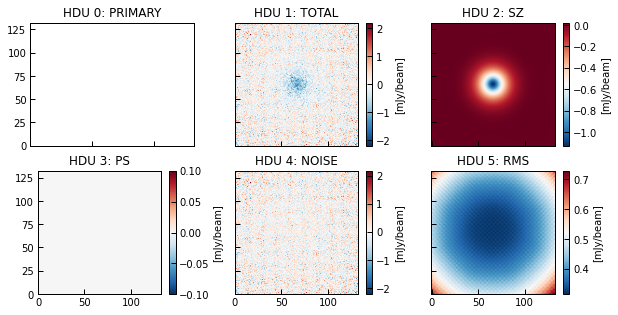

In [8]:
fig, axs = plt.subplots(2, 3, figsize=(10, 5), sharex=True, sharey=True)
hdulist = fits.open(f"{path}/simulated_map.fits")
for i, ax in enumerate(axs.flatten()):
    h = hdulist[i]
    ax.set_title(f"HDU {i}: {h.name}")
    if i != 0:
        im = ax.imshow(1e3 * h.data, origin="lower", cmap="RdBu_r")
        cb = fig.colorbar(im, ax=ax)
        cb.set_label("[mJy/beam]")

## Exploitation

The FITS file created above contains the required data inputs for `panco2` to fit a pressure profile, and can be used to study the impact of analysis choices.
For example, we can try to fit the map with different binings:

1. 10 pressure bins, log-spaced from the deprojected pixel size to the half map size;
3. 5 pressure bins, log-spaced from the deprojected pixel size to the half map size.

In [9]:
pix_kpc = ppf.cluster.arcsec2kpc(ppf.pix_size)
half_map_kpc = ppf.cluster.arcsec2kpc(ppf.map_size * 60 / 2)

binnings = [
    np.logspace(np.log10(pix_kpc), np.log10(half_map_kpc), 10),
    np.logspace(np.log10(pix_kpc), np.log10(half_map_kpc), 5),
]

We run two fits, one for each binning choice, with the other analysis options being the same as for the NIKA2 view of C2 presented in the validation paper, and compare:
- The parameter correlations
- How well the recovered pressure profiles agree with the truth

Start by initializing a new `PressureProfileFitter` object with the newly created input map:

In [10]:
ppf = p2.PressureProfileFitter(
    f"{path}/simulated_map.fits",
    1, 5,
    0.5, 6e14,
    map_size=6.5,
    coords_center=SkyCoord("12h00m00s +00d00m00s")
)

### Binning #0

First of all, convergence is a lot slower with a larger number of bins.
This is expected, as we are sampling in a 12 dimensional parameter space for binning 1, compared to only 7 dimensions for binning 2.

Moreover, the narrow spacing between bins intrinsically creates correlations between nearby bins in the parameter space.
As a result, we can see in the posterior plot that for binning #1, the first three parameters (i.e. the pressure at the three inner radial bins) are prior-dominated.
This also results in an underestimated pressure within 100 kpc.

==> Adding filtering: beam and 1D transfer function
I'll check convergence every 500 steps, and stop when the autocorrelation length `tau` has changed by less than 5.0% twice in a row, and the chain is longer than 50*tau


/Users/fkeruzore/.miniconda3/envs/panco2/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


    500 iterations = 10.3*tau (tau = 48.4 -> dtau/tau = 1.0000)
    1000 iterations = 11.5*tau (tau = 87.0 -> dtau/tau = 0.4440)
    1500 iterations = 11.9*tau (tau = 126.5 -> dtau/tau = 0.3122)
    2000 iterations = 12.4*tau (tau = 161.6 -> dtau/tau = 0.2168)
    2500 iterations = 12.2*tau (tau = 205.2 -> dtau/tau = 0.2128)
    3000 iterations = 12.2*tau (tau = 245.7 -> dtau/tau = 0.1646)
    3500 iterations = 12.6*tau (tau = 278.7 -> dtau/tau = 0.1186)
    4000 iterations = 12.7*tau (tau = 315.2 -> dtau/tau = 0.1157)
    4500 iterations = 12.8*tau (tau = 351.7 -> dtau/tau = 0.1038)
    5000 iterations = 12.9*tau (tau = 387.8 -> dtau/tau = 0.0931)
    5500 iterations = 12.6*tau (tau = 436.9 -> dtau/tau = 0.1125)
    6000 iterations = 12.4*tau (tau = 483.3 -> dtau/tau = 0.0959)
    6500 iterations = 12.3*tau (tau = 526.9 -> dtau/tau = 0.0828)
    7000 iterations = 12.4*tau (tau = 562.8 -> dtau/tau = 0.0639)
    7500 iterations = 12.7*tau (tau = 591.0 -> dtau/tau = 0.0477)
    8000 iter

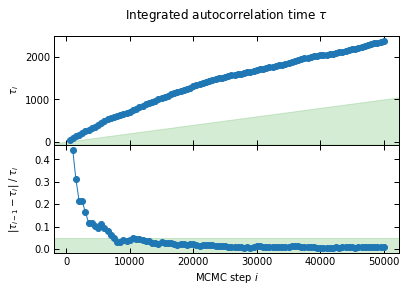

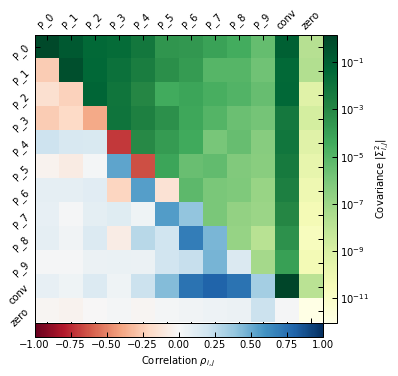

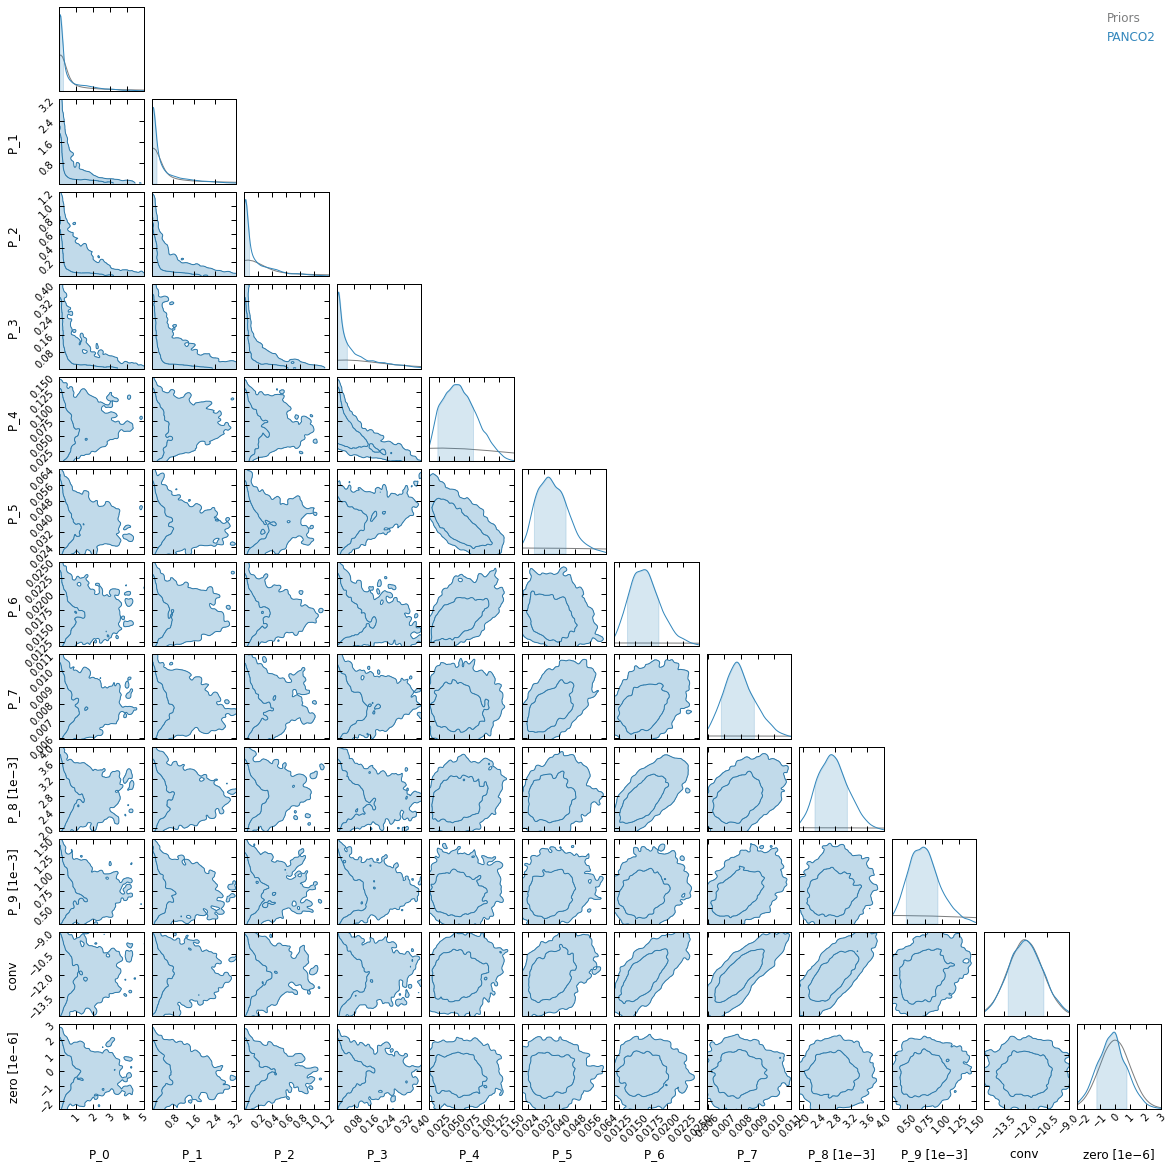

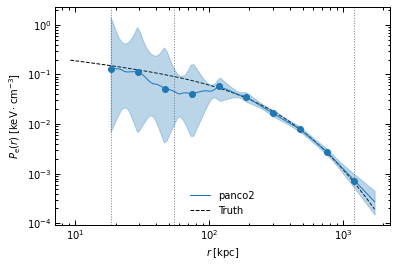

In [11]:
i = 0
r_bins = binnings[i]
ppf.define_model(r_bins)

ppf.add_filtering(
    beam_fwhm=beam_fwhm_arcsec, ell=tf["ell"], tf=tf["tf_150GHz"], pad=20
)

P_bins = p2.utils.gNFW(r_bins, *ppf.cluster.A10_params)
ppf.define_priors(
    P_bins=[ss.loguniform(0.01 * P, 100.0 * P) for P in P_bins],
    conv=ss.norm(-12.0, 1.2),
    zero=ss.norm(0.0, 1e-6)
)

np.random.seed(42)
_ = ppf.run_mcmc(
    30, 5e4, 4, n_check=5e2, max_delta_tau=0.05, min_autocorr_times=50, 
    out_chains_file=f"{path}/rawchains_{i}.npz", 
    plot_convergence=f"{path}/mcmc_convergence_{i}.pdf",
    progress=False
)

chains_clean = p2.results.load_chains(
    f"{path}/rawchains_{i}.npz", 500, 50, clip_percent=20.0, verbose=True
)

fig.savefig(f"{path}/mcmc_convergence_{i}.pdf")
p2.results.mcmc_matrices_plot(
    chains_clean, ppf, filename=f"{path}/mcmc_matrices_{i}.pdf"
)
p2.results.mcmc_corner_plot(
    chains_clean, ppf=ppf, show_probs=False,
    filename=f"{path}/mcmc_corner_{i}.pdf", 
)

r_range = np.logspace(
    np.log10(pix_kpc), np.log10(half_map_kpc * np.sqrt(2)), 100
)
fig, ax = p2.results.plot_profile(
    chains_clean, ppf, r_range=r_range, label="panco2", color="tab:blue"
)
ax.plot(true_prof[0], true_prof[1], "k--", label="Truth")
ax.legend(frameon=False)
fig.savefig(f"{path}/pressure_profile_{i}.pdf")

### Binning #2

On the other hand, binning #2 is coarser and offers less detailed information on the shape of the profile, but the larger spacing between the bins makes pressure reconstruction more accurate in the cluster center.
This coarser binning also results in a worse reconstruction at large radii, especially the extrapolation beyond the last pressure bin.

==> Adding filtering: beam and 1D transfer function
I'll check convergence every 500 steps, and stop when the autocorrelation length `tau` has changed by less than 5.0% twice in a row, and the chain is longer than 50*tau


/Users/fkeruzore/.miniconda3/envs/panco2/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


    500 iterations = 12.3*tau (tau = 40.7 -> dtau/tau = 1.0000)
    1000 iterations = 15.2*tau (tau = 65.9 -> dtau/tau = 0.3824)
    1500 iterations = 18.0*tau (tau = 83.6 -> dtau/tau = 0.2115)
    2000 iterations = 20.4*tau (tau = 98.3 -> dtau/tau = 0.1497)
    2500 iterations = 21.3*tau (tau = 117.2 -> dtau/tau = 0.1614)
    3000 iterations = 23.0*tau (tau = 130.3 -> dtau/tau = 0.1005)
    3500 iterations = 24.6*tau (tau = 142.4 -> dtau/tau = 0.0852)
    4000 iterations = 27.8*tau (tau = 143.7 -> dtau/tau = 0.0089)
    4500 iterations = 30.6*tau (tau = 147.3 -> dtau/tau = 0.0245)
    5000 iterations = 32.8*tau (tau = 152.2 -> dtau/tau = 0.0325)
    5500 iterations = 35.1*tau (tau = 156.7 -> dtau/tau = 0.0286)
    6000 iterations = 38.5*tau (tau = 155.9 -> dtau/tau = 0.0051)
    6500 iterations = 41.0*tau (tau = 158.5 -> dtau/tau = 0.0163)
    7000 iterations = 43.0*tau (tau = 162.9 -> dtau/tau = 0.0272)
    7500 iterations = 44.8*tau (tau = 167.6 -> dtau/tau = 0.0278)
    8000 iterat

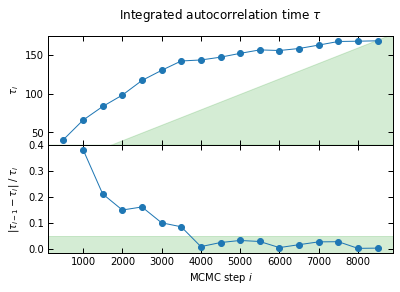

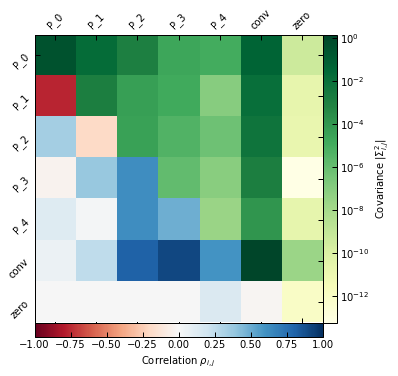

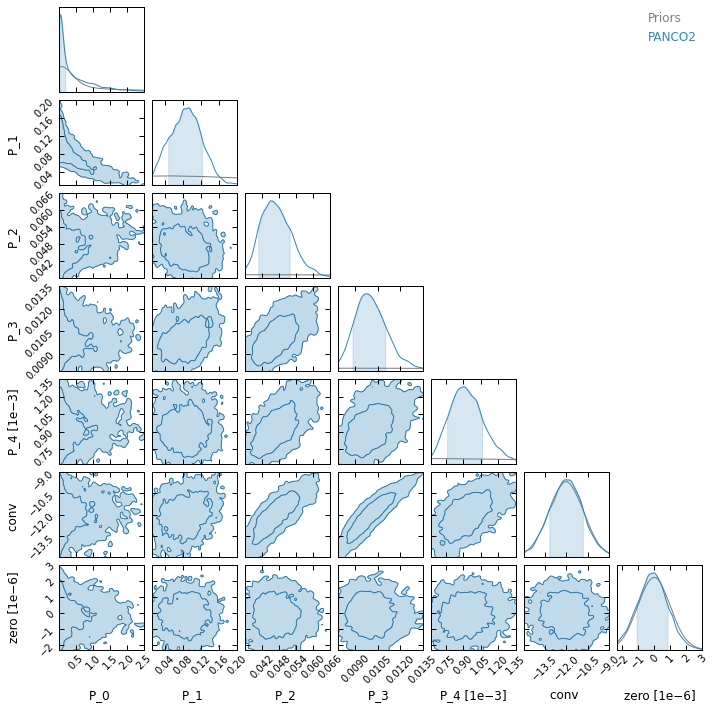

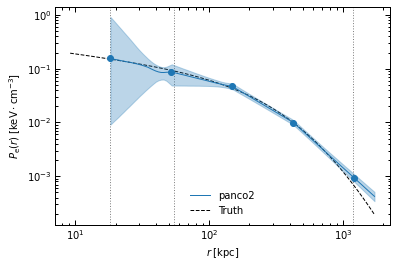

In [12]:
i = 1
r_bins = binnings[i]
ppf.define_model(r_bins)

ppf.add_filtering(
    beam_fwhm=beam_fwhm_arcsec, ell=tf["ell"], tf=tf["tf_150GHz"], pad=20
)

P_bins = p2.utils.gNFW(r_bins, *ppf.cluster.A10_params)
ppf.define_priors(
    P_bins=[ss.loguniform(0.01 * P, 100.0 * P) for P in P_bins],
    conv=ss.norm(-12.0, 1.2),
    zero=ss.norm(0.0, 1e-6)
)

np.random.seed(42)
_ = ppf.run_mcmc(
    30, 5e4, 4, n_check=5e2, max_delta_tau=0.05, min_autocorr_times=50, 
    out_chains_file=f"{path}/rawchains_{i}.npz", 
    plot_convergence=f"{path}/mcmc_convergence_{i}.pdf",
    progress=False
)

chains_clean = p2.results.load_chains(
    f"{path}/rawchains_{i}.npz", 500, 50, clip_percent=20.0, verbose=True
)

p2.results.mcmc_matrices_plot(
    chains_clean, ppf, filename=f"{path}/mcmc_matrices_{i}.pdf"
)
p2.results.mcmc_corner_plot(
    chains_clean, ppf=ppf, show_probs=False,
    filename=f"{path}/mcmc_corner_{i}.pdf", 
)

r_range = np.logspace(
    np.log10(pix_kpc), np.log10(half_map_kpc * np.sqrt(2)), 100
)
fig, ax = p2.results.plot_profile(
    chains_clean, ppf, r_range=r_range, label="panco2", color="tab:blue"
)
ax.plot(true_prof[0], true_prof[1], "k--", label="Truth")
ax.legend(frameon=False)
fig.savefig(f"{path}/pressure_profile_{i}.pdf")

A caveat of this simulation-based check is that it assumes you know the mass of the cluster being investigated, as well as its pressure profile.
The wronger these estimates are (and they are likely to be, otherwise you wouldn't be using `panco2` to fit the cluster's pressure profile), the less the generated data will be representative of the actual input.
Nonetheless, it can be used to check, e.g. the impact of priors, of masking point sources vs. fitting them, of adding a $Y_{500}$ constraint, etc -- opening a wide range of systematic studies.